In [6]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

In [7]:
# Check if CUDA (GPU) is available and set the device accordingly
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [8]:
# Define data transformations for image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.1,), (0.3,))  # Normalize pixel values
])


In [9]:
# Create a training dataset and dataloader
train_set = datasets.MNIST('Data_MNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 118071222.76it/s]


Extracting Data_MNIST/MNIST/raw/train-images-idx3-ubyte.gz to Data_MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 46554840.06it/s]

Extracting Data_MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to Data_MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35563316.12it/s]


Extracting Data_MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to Data_MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13444268.71it/s]


Extracting Data_MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to Data_MNIST/MNIST/raw



In [10]:

# Create a test dataset and dataloader
test_set = datasets.MNIST('DATA_MNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 77964301.58it/s]


Extracting DATA_MNIST/MNIST/raw/train-images-idx3-ubyte.gz to DATA_MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 53957992.79it/s]

Extracting DATA_MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to DATA_MNIST/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 36249850.07it/s]


Extracting DATA_MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to DATA_MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5576852.68it/s]

Extracting DATA_MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to DATA_MNIST/MNIST/raw



In [11]:

# Enumerate the training data to understand its structure
training_data = enumerate(trainloader)
batch_idx, (images, labels) = next(training_data)
print(type(images))
print(images.shape)  # Shape of the batch of images (64 images, 1 channel, 28x28 pixels)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


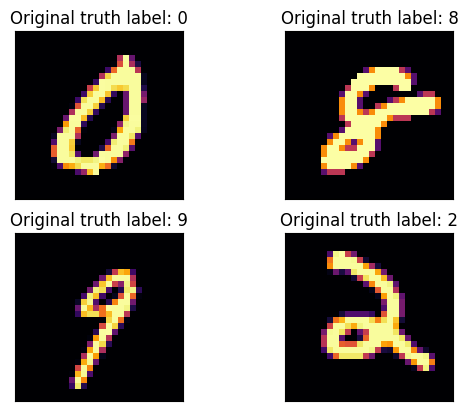

In [14]:
# Show 4 sample images with their labels
fig = plt.figure()
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i][0], cmap='inferno')
    plt.title('Original truth label: {}'.format(labels[i]))
    plt.yticks([])
    plt.xticks([])
plt.show()

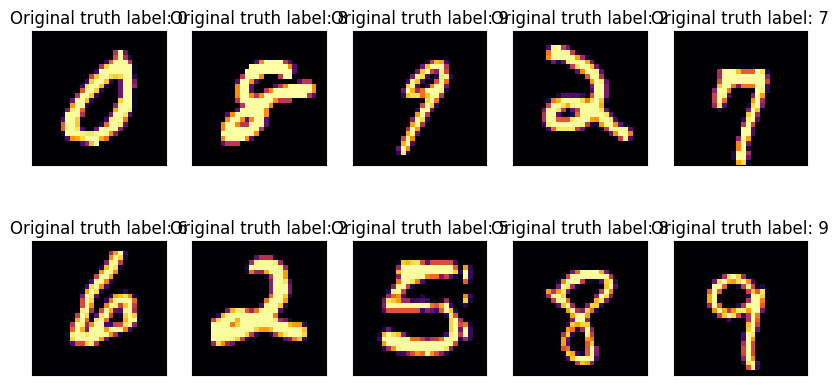

In [15]:
# Show 10 sample images with their labels
fig = plt.figure(figsize=(10, 5))  # Create a larger figure to accommodate 10 images
for i in range(10):
    plt.subplot(2, 5, i + 1)  # Create a 2x5 grid for 10 images
    plt.imshow(images[i][0], cmap='inferno')
    plt.title('Original truth label: {}'.format(labels[i]))
    plt.yticks([])
    plt.xticks([])
plt.show()


In [16]:

# Define a neural network class named "Network"
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional_neural_network_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(24 * 7 * 7, out_features=64),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # Dropout layer to prevent overfitting
            nn.Linear(in_features=64, out_features=10)
        )

    def forward(self, x):
        x = self.convolutional_neural_network_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output for fully connected layers
        x = self.linear_layers(x)
        x = F.log_softmax(x, dim=1)
        return x


In [17]:
model = Network()
model.to(device)
print(model)

Network(
  (convolutional_neural_network_layers): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1176, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [18]:
# Define the optimizer (Stochastic Gradient Descent) and loss function (Cross Entropy Loss)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Define the number of training epochs
epochs = 10


In [19]:
# Lists to store training and testing losses
train_losses = []
test_losses = []

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for idx, (images, labels) in enumerate(trainloader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        output = model(images)
        loss = criterion(output, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    else:
        # Prepare the model for evaluation
        model.eval()
        test_loss = 0
        accuracy = 0

        # Turn off gradients and run the evaluation phase
        with torch.no_grad():
            for images, labels in testloader:
                images = images.to(device)
                labels = labels.to(device)

                log_probabilities = model(images)
                test_loss += criterion(log_probabilities, labels)

                probabilities = torch.exp(log_probabilities)
                top_prob, top_class = probabilities.topk(1, dim=1)
                predictions = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(predictions.type(torch.FloatTensor))

        # Append training and testing losses to their respective lists
        train_losses.append(train_loss / len(trainloader))
        test_losses.append(test_loss / len(testloader))

        # Print training and testing results for the current epoch
        print("Epoch [{}/{}]".format(epoch + 1, epoch),
              "Training loss: {:.4f}".format(train_loss / len(trainloader)),
              "Testing loss: {:.4f}".format(test_loss / len(testloader)),
              "Test accuracy: {:.4f}".format(accuracy / len(testloader)))


Epoch [1/0] Training loss: 0.7119 Testing loss: 0.2031 Test accuracy: 0.9400
Epoch [2/1] Training loss: 0.2107 Testing loss: 0.1227 Test accuracy: 0.9621
Epoch [3/2] Training loss: 0.1520 Testing loss: 0.0915 Test accuracy: 0.9706
Epoch [4/3] Training loss: 0.1259 Testing loss: 0.0789 Test accuracy: 0.9738
Epoch [5/4] Training loss: 0.1075 Testing loss: 0.0703 Test accuracy: 0.9780
Epoch [6/5] Training loss: 0.0953 Testing loss: 0.0614 Test accuracy: 0.9795
Epoch [7/6] Training loss: 0.0874 Testing loss: 0.0585 Test accuracy: 0.9808
Epoch [8/7] Training loss: 0.0799 Testing loss: 0.0511 Test accuracy: 0.9831
Epoch [9/8] Training loss: 0.0741 Testing loss: 0.0476 Test accuracy: 0.9847
Epoch [10/9] Training loss: 0.0695 Testing loss: 0.0456 Test accuracy: 0.9843


In [20]:
import matplotlib.pyplot as plt


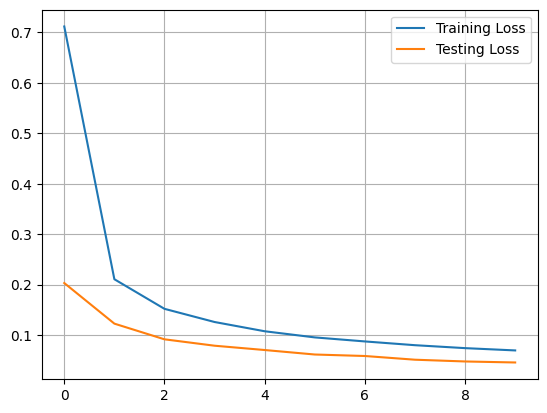

In [21]:
# Plot the training and testing loss curves
plt.plot(train_losses,label="Training Loss")
plt.plot(test_losses,label="Testing Loss")
plt.legend()
plt.grid()

In [22]:
# Test the model with a sample image
img = images[3]
img = img.to(device)
img = img.view(-1,1,28,28)
print(img)

tensor([[[[-0.3333, -0.3333, -0.3333, -0.3333, -0.3333, -0.3333, -0.3333,
           -0.3333, -0.3333, -0.3333, -0.3333, -0.3333, -0.3333, -0.3333,
           -0.3333, -0.3333, -0.3333, -0.3333, -0.3333, -0.3333, -0.3333,
           -0.3333, -0.3333, -0.3333, -0.3333, -0.3333, -0.3333, -0.3333],
          [-0.3333, -0.3333, -0.3333, -0.3333, -0.3333, -0.3333, -0.3333,
           -0.3333, -0.3333, -0.3333, -0.3333, -0.3333, -0.3333, -0.3333,
           -0.3333, -0.3333, -0.3333, -0.3333, -0.3333, -0.3333, -0.3333,
           -0.3333, -0.3333, -0.3333, -0.3333, -0.3333, -0.3333, -0.3333],
          [-0.3333, -0.3333, -0.3333, -0.3333, -0.3333, -0.3333, -0.3333,
           -0.3333, -0.3333, -0.3333, -0.3333, -0.3333, -0.3333, -0.3333,
           -0.3333, -0.3333, -0.3333, -0.3333, -0.3333, -0.3333, -0.3333,
           -0.3333, -0.3333, -0.3333, -0.3333, -0.3333, -0.3333, -0.3333],
          [-0.3333, -0.3333, -0.3333, -0.3333, -0.3333, -0.3333, -0.3333,
           -0.3333, -0.3333, -0.333

In [23]:
with torch.no_grad():
    logits = model.forward(img)

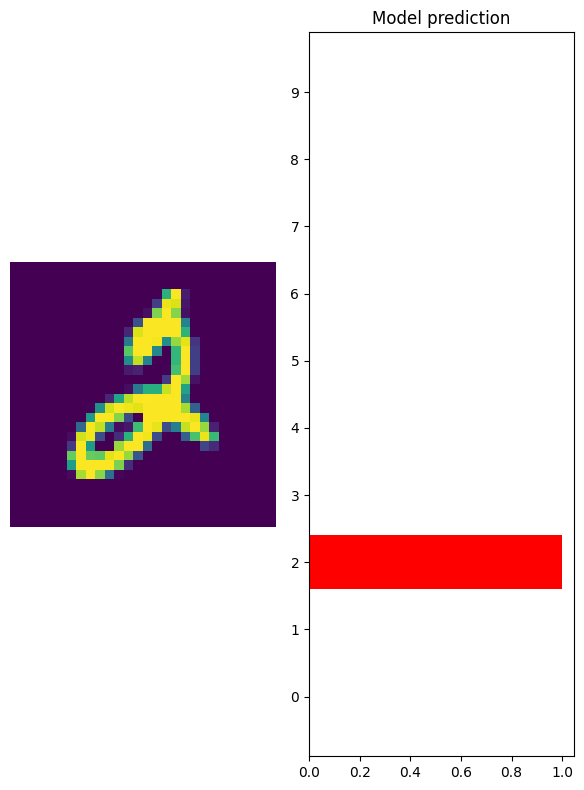

In [24]:

# tset time

probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()
fig, (ax1,ax2) = plt.subplots(figsize=(6,8),ncols =2)
ax1.imshow(img.view(1,28,28).detach().cpu().numpy().squeeze())
ax1.axis('off')

ax2.barh(np.arange(10),probabilities, color='r')
ax2.set_yticks(np.arange(10))
ax2.set_title('Model prediction')

plt.tight_layout()

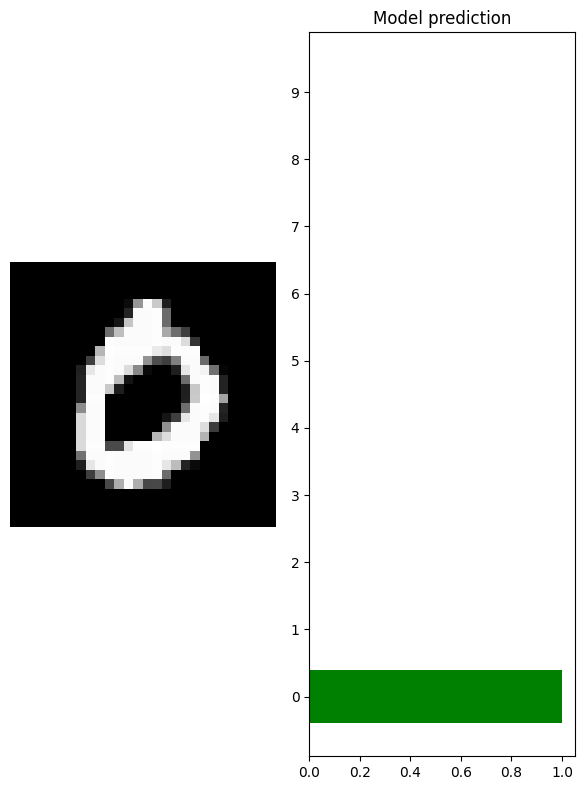

In [45]:
# Assuming you have logits from your model
model.eval()  # Set the model to evaluation mode

# Replace 'example_index' with the actual index of the test image you want to visualize img = test_set[example_index][0].to(device)
img = test_set[3][0].to(device)

with torch.no_grad():
    logits = model(img.unsqueeze(0))  # Forward pass for the single image

# Calculate probabilities and visualize
probabilities = F.softmax(logits, dim=1).cpu().numpy().squeeze()
fig, (ax1, ax2) = plt.subplots(figsize=(6, 8), ncols=2)
ax1.imshow(img.cpu().numpy().squeeze(), cmap='gray')  # Display the image
ax1.axis('off')

ax2.barh(np.arange(10), probabilities, color='g')  # Display predicted probabilities for each class
ax2.set_yticks(np.arange(10))
ax2.set_title('Model prediction')

plt.tight_layout()
plt.show()


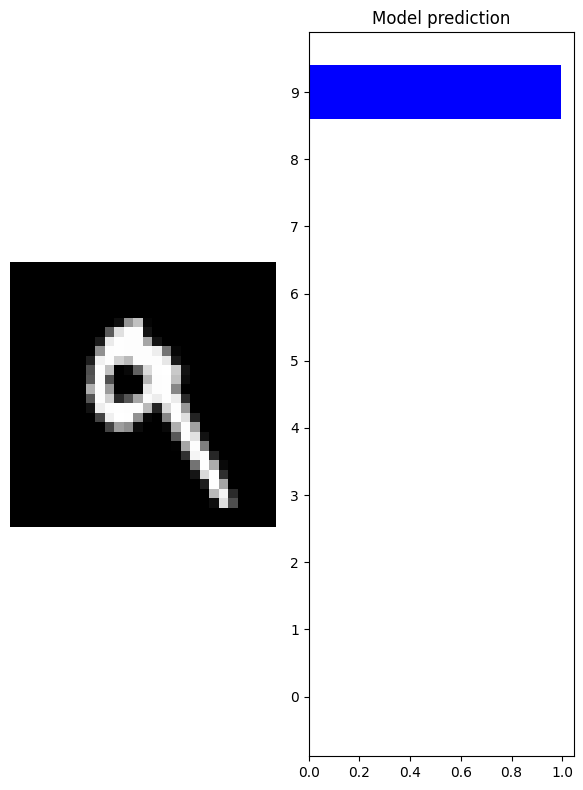

In [44]:
# Assuming you have logits from your model
model.eval()  # Set the model to evaluation mode

# Replace 'example_index' with the actual index of the test image you want to visualize img = test_set[example_index][0].to(device)
img = test_set[7][0].to(device)

with torch.no_grad():
    logits = model(img.unsqueeze(0))  # Forward pass for the single image

# Calculate probabilities and visualize
probabilities = F.softmax(logits, dim=1).cpu().numpy().squeeze()
fig, (ax1, ax2) = plt.subplots(figsize=(6, 8), ncols=2)
ax1.imshow(img.cpu().numpy().squeeze(), cmap='gray')  # Display the image
ax1.axis('off')

ax2.barh(np.arange(10), probabilities, color='b')  # Display predicted probabilities for each class
ax2.set_yticks(np.arange(10))
ax2.set_title('Model prediction')

plt.tight_layout()
plt.show()

Confusion Matrix: You can create a confusion matrix to visualize how well your model is performing for each class (0-9). This will give you insights into which digits are often confused with each other.

In [26]:
true_labels = []
for images, labels in testloader:
    true_labels.extend(labels.tolist())  # Assuming labels is a tensor


In [28]:
predicted_labels = []
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, _ in testloader:  # Iterate through the testloader, ignore true labels (_)
        images = images.to(device)  # Move data to GPU if available
        logits = model(images)  # Forward pass to get model predictions
        _, predicted = torch.max(logits, 1)  # Get the class index with highest probability
        predicted_labels.extend(predicted.cpu().numpy())  # Move predictions to CPU and convert to a list


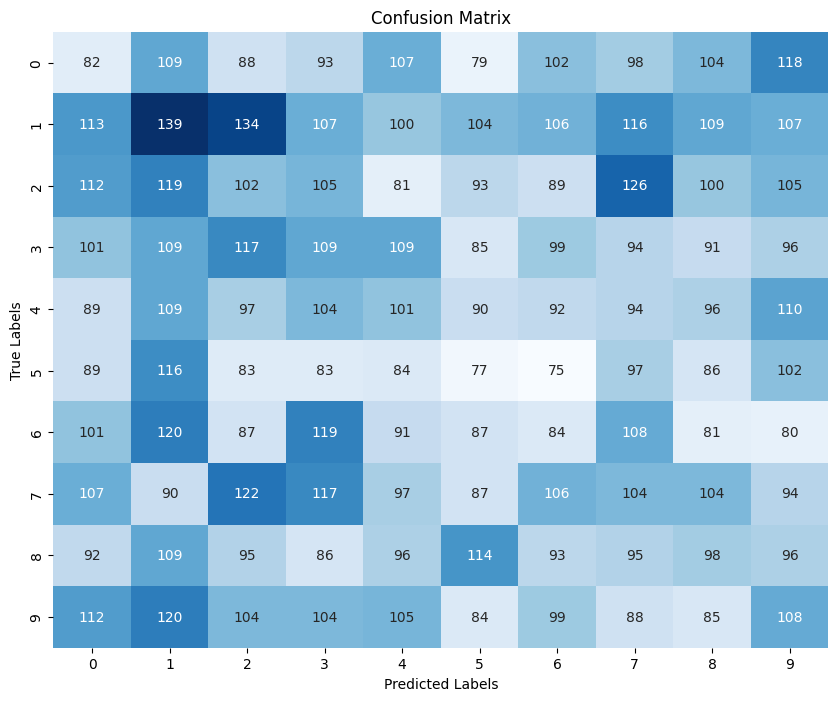

In [30]:
# Replace true_labels and predicted_labels with your actual data
#true_labels = [0, 1, 2, ...]  # Replace with the true labels for your test data
#predicted_labels = [0, 1, 2, ...]  # Replace with the predicted labels from your model

# Calculate the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


ROC Curve: If you're working on a binary classification problem (e.g., distinguishing between two digits), you can plot the Receiver Operating Characteristic (ROC) curve to visualize the trade-off between true positive rate and false positive rate at different thresholds.

This code assumes that you have a binary classification problem, and it calculates the ROC curve and AUC for class 1 (positive class). Make sure to adjust the indices accordingly if you have a different number of classes or if the positive class is different.

we modify the labels to represent odd (1) and even (0) numbers and then calculate the ROC curve and AUC for the binary classification task.

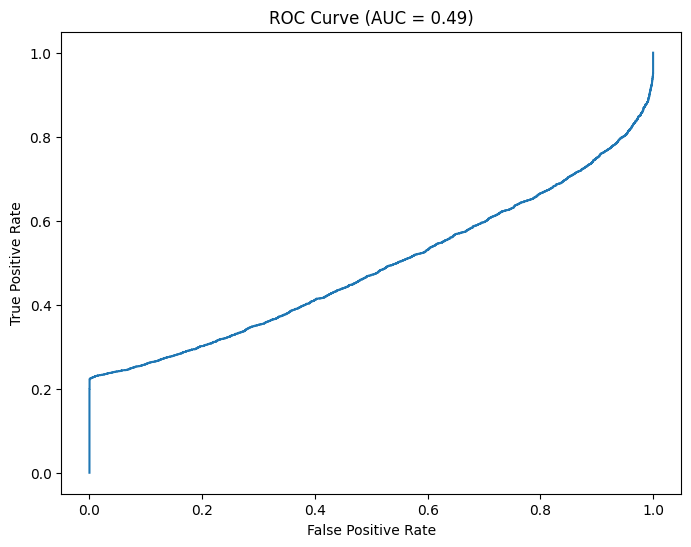

In [35]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming you have logits from your model
model.eval()  # Set the model to evaluation mode
predicted_probabilities = []  # List to store predicted probabilities
true_labels = []  # List to store true labels

with torch.no_grad():
    for images, labels in testloader:  # Iterate through the testloader
        images = images.to(device)  # Move data to GPU if available
        logits = model(images)  # Forward pass to get model logits
        probabilities = torch.softmax(logits, dim=1)  # Convert logits to probabilities

        # Modify labels to represent odd (1) and even (0)
        modified_labels = (labels % 2).cpu().numpy()
        true_labels.extend(modified_labels)  # Extend the list of true labels
        predicted_probabilities.extend(probabilities[:, 1].cpu().numpy())  # Extend the list of predicted probabilities for class 1

# Convert to NumPy arrays
predicted_probabilities = np.array(predicted_probabilities)
true_labels = np.array(true_labels)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)
roc_auc = roc_auc_score(true_labels, predicted_probabilities)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {roc_auc:.2f})')
plt.show()


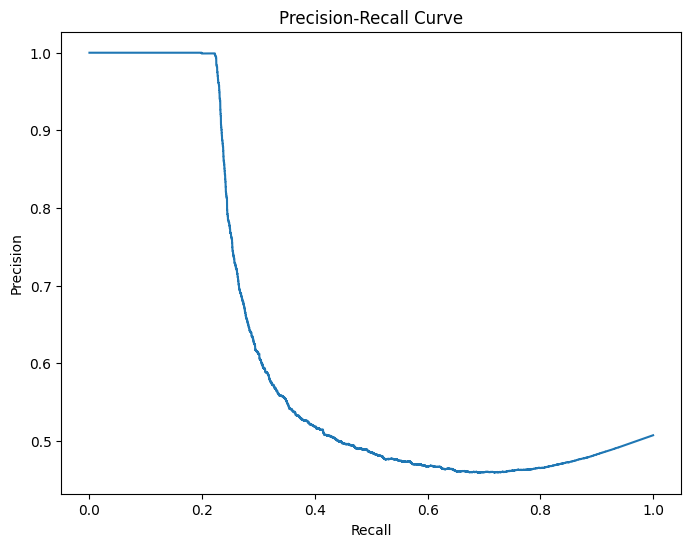

In [36]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(true_labels, predicted_probabilities)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


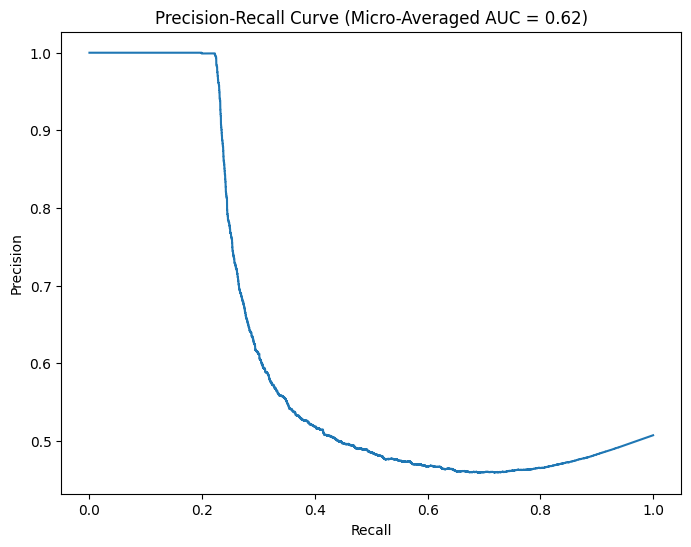

In [37]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate precision-recall curve and micro-averaged AUC
precision, recall, _ = precision_recall_curve(true_labels, predicted_probabilities, pos_label=1)
average_precision = average_precision_score(true_labels, predicted_probabilities, average='micro')

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (Micro-Averaged AUC = {average_precision:.2f})')
plt.show()
